<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees as Surrogate Model for NNs

* https://arxiv.org/abs/1904.05394
* https://colab.research.google.com/github/djcordhose/ml-workshop/blob/master/notebooks/classic/dt-intro.ipynb

In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

import numpy as np

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=15
title_font_size=25

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   legend=False, # colab has old version of matplotlib, does not support
                   ax=None
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

num_features = 2
num_categories = 3

# dropout
# 0.80222225 / 0.77
# L1 

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

model.add(Dense(name='hidden1', 
                units=1500,
                kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='hidden2', 
               units=1500,
               kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(Dropout(dropout))

# model.add(Dense(name='hidden3', 
#                 units=1500,
#                 kernel_regularizer=regularizers.l1(0.01)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 1500)              4500      
_________________________________________________________________
activation (Activation)      (None, 1500)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1500)              6000      
_________________________________________________________________
hidden2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
activation_1 (Activation)    (None, 1500)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1500)              6000      
_________________________________________________________________
output (Dense)               (None, 3)                 4

In [11]:
%%time 

BATCH_SIZE = 10
EPOCHS = 1000

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    # validation_split=0.2, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 12min 13s, sys: 2min 27s, total: 14min 40s
Wall time: 13min 20s


In [12]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(3.3473592678705852, 0.6666667)

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(3.324561647574107, 0.685)

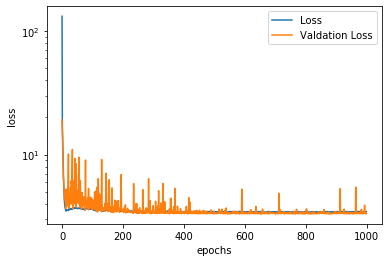

In [14]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

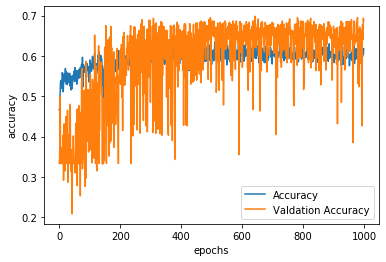

In [15]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5085692e48>,
 <matplotlib.collections.PathCollection at 0x7f508530f780>)

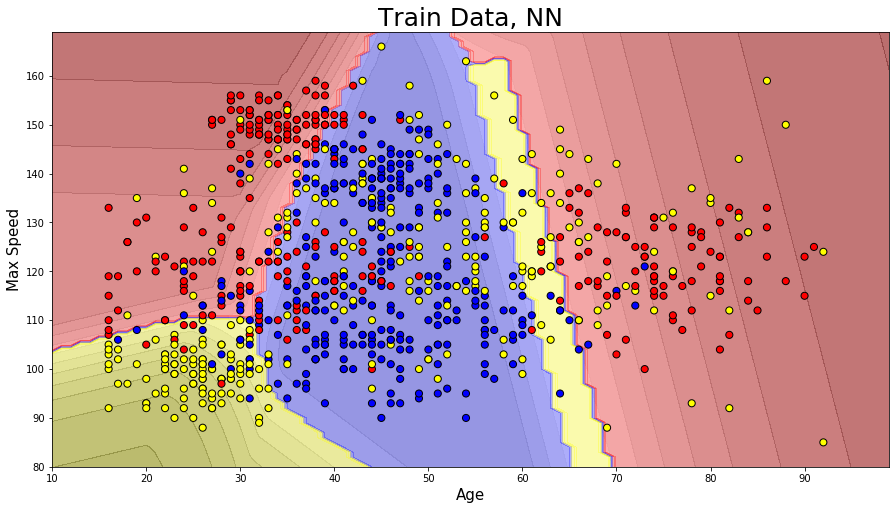

In [16]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f50852d6b70>,
 <matplotlib.collections.PathCollection at 0x7f5085263ef0>)

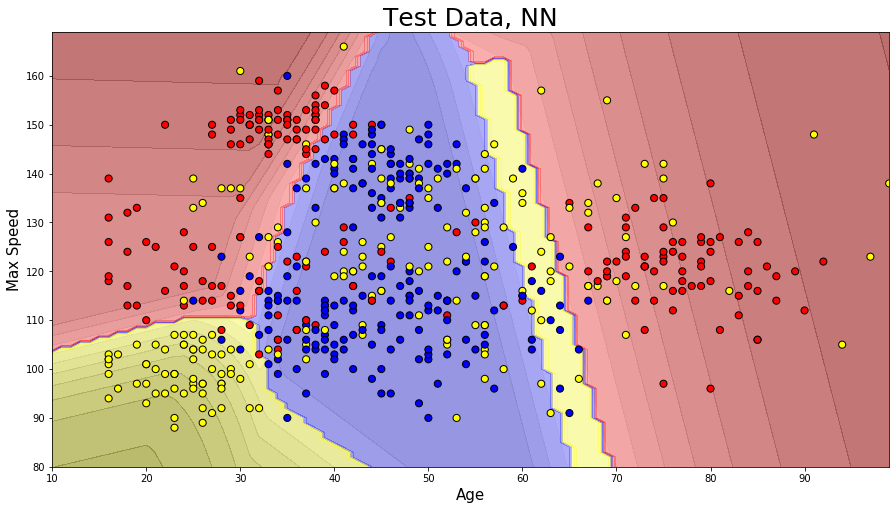

In [17]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

In [37]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 90), (90, 90))

In [38]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(8100, 2)

In [39]:
pred = model.predict(mesh_data)
pred.shape

(8100, 3)

In [40]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(8100,)

In [42]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4957, 2093, 1050]))

### Direct Training Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 3.73 ms, sys: 333 µs, total: 4.06 ms
Wall time: 4.31 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [73]:
dt_model.score(X_train_2_dim, y_train)

0.96

In [74]:
dt_model.score(X_test_2_dim, y_test)

0.6

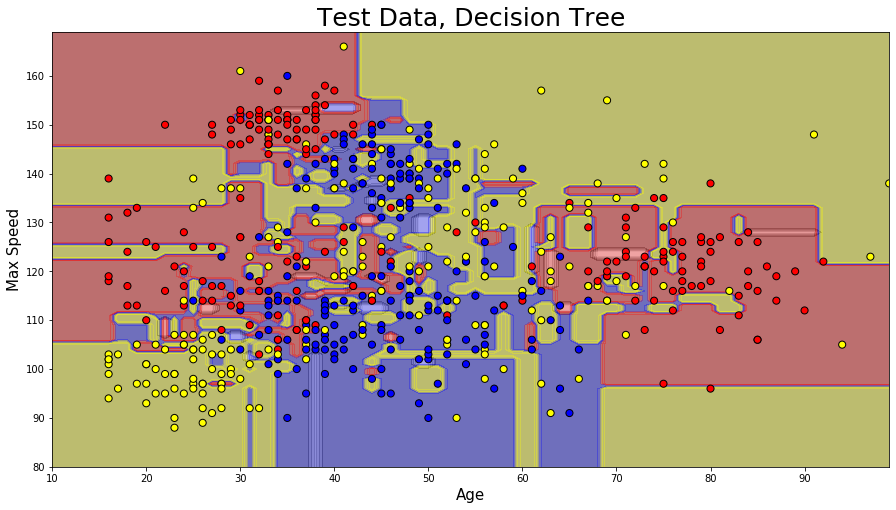

In [60]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

### Surrogate Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.29 ms, sys: 954 µs, total: 10.2 ms
Wall time: 13.2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

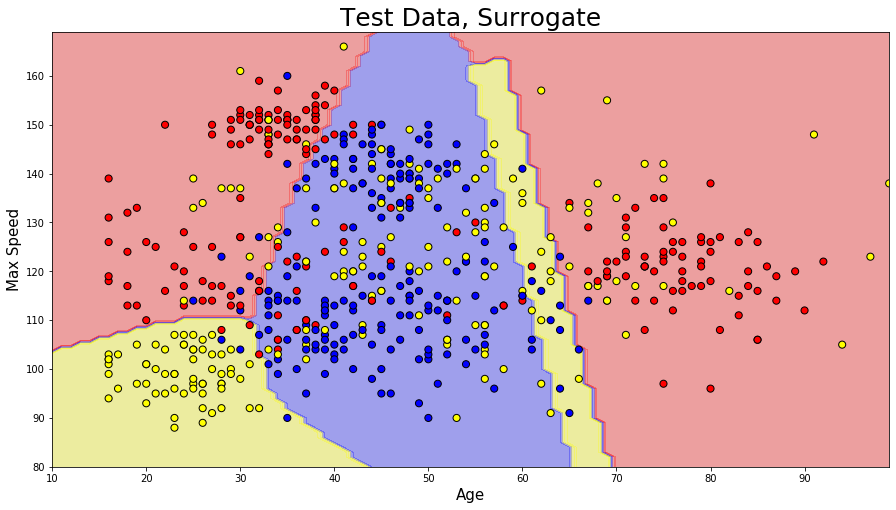

In [62]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [63]:
surrogate_model.tree_.max_depth

12

In [64]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [66]:
surrogate_model.score(X_train_2_dim, y_train)

0.6666666666666666

In [65]:
surrogate_model.score(X_test_2_dim, y_test)

0.685

## Reduce Depth: 5

In [67]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.41 ms, sys: 863 µs, total: 8.27 ms
Wall time: 9.22 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [68]:
surrogate_model.tree_.max_depth

5

In [69]:
surrogate_model.score(mesh_data, pred_sparse)

0.9471604938271605

In [70]:
surrogate_model.score(X_train_2_dim, y_train)

0.6477777777777778

In [71]:
surrogate_model.score(X_test_2_dim, y_test)

0.6733333333333333

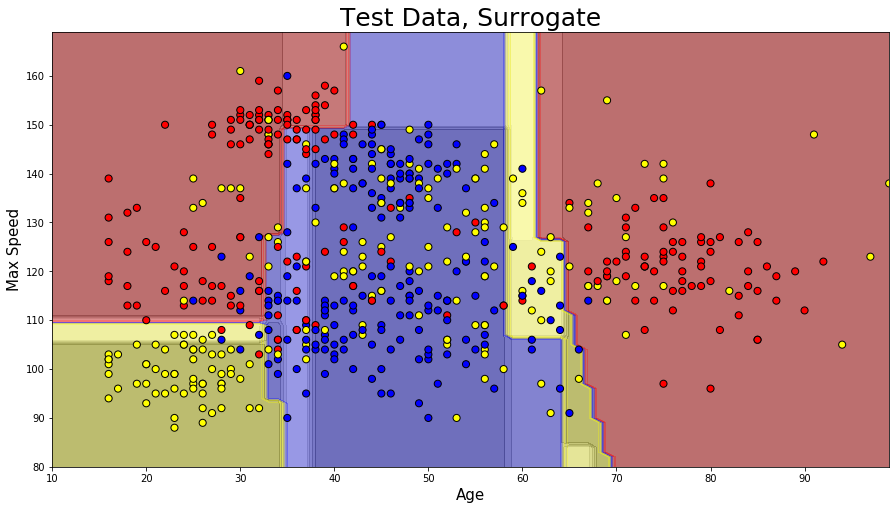

In [72]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 3

In [108]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=250)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.16 ms, sys: 2.07 ms, total: 6.23 ms
Wall time: 9.79 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=250, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [109]:
surrogate_model.tree_.max_depth

3

In [110]:
surrogate_model.score(mesh_data, pred_sparse)

0.8908641975308642

In [111]:
surrogate_model.score(X_train_2_dim, y_train)

0.6111111111111112

In [112]:
surrogate_model.score(X_test_2_dim, y_test)

0.6166666666666667

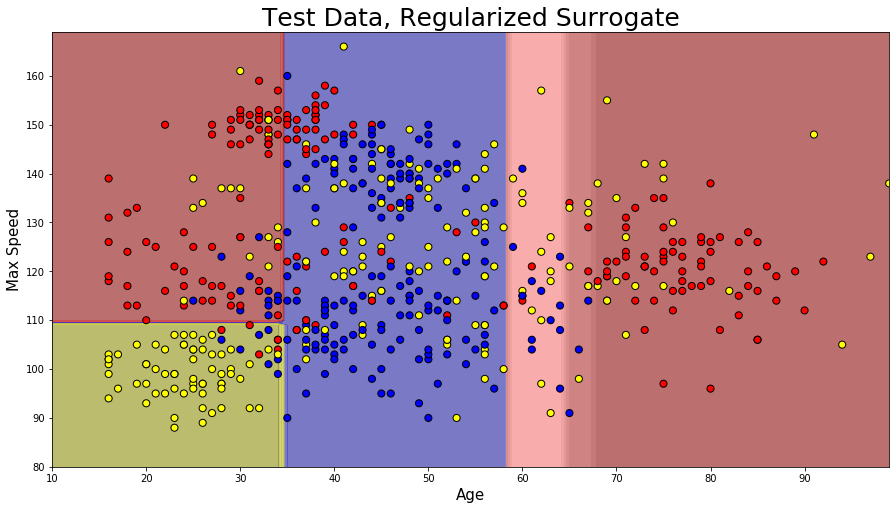

In [113]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

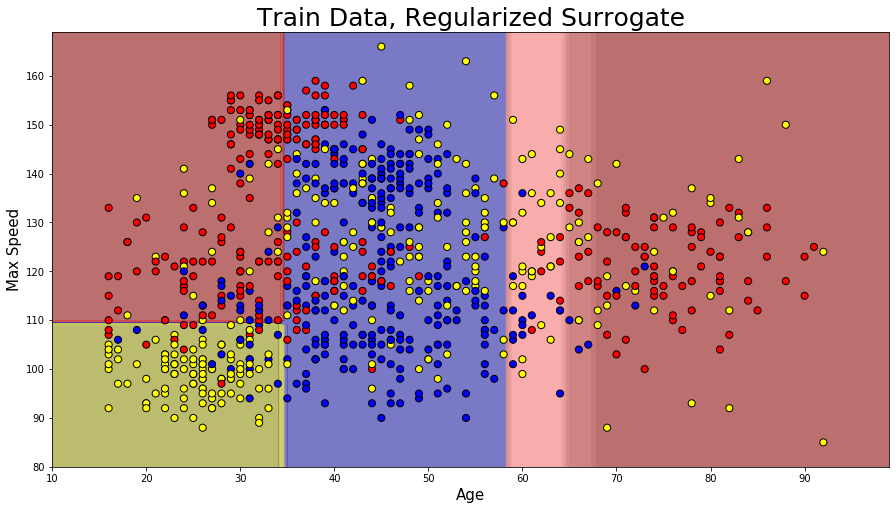

In [114]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");